https://www.sciencedirect.com/science/article/pii/S2352484721004509

In [24]:
import jax
import jax.numpy as jnp
from jax.scipy import optimize
import matplotlib.pyplot as plt

In [25]:
nParams = 7 #Numero de parametros
panelType = 'RTC'

Tablas

In [26]:
if panelType == 'RTC':
  #Table 6 - France
  VL = jnp.array([-0.2057,-0.1291,-0.0588,0.0057,0.0646,0.1185,0.1678,0.2132,0.2545,0.2924,0.3269,\
                0.3585,0.3873,0.4137,0.4373,0.4590,0.4784,0.4960,0.5119,0.5265,0.5398,0.5521,\
                0.5633,0.5736,0.5833,0.5900])

  IL = jnp.array([0.7640,0.7620,0.7605,0.7605,0.7600,0.7590,0.7570,0.7570,0.7555,0.7540,0.7505,\
                0.7465,0.7385,0.7280,0.7065,0.6755,0.6320,0.5730,0.4990,0.4130,0.3165,0.2120,\
                0.1035,-0.0100,-0.1230,-0.2100])

  #             Iph, Rs,  Rsh,Isd,  n,Is2, n2,Is3, n3
  lb=jnp.array([0.0,0.0,  0.0,0.0,1.0,0.0,1.0,0.0,2.0])
  ub=jnp.array([1.0,0.5,100.0,1.0,2.0,1.0,2.0,1.0,5.0])
  T = 33
  mu = 10
  if nParams == 5:
    bestParams = jnp.array([0.76077551, 0.0363771, 53.71867407, 0.32302031, 1.48110808])
  elif nParams == 7:
    bestParams = jnp.array([0.76078094, 0.03672887, 55.42643282, 0.228574, 1.451895, 0.727182, 2.0])
  else:
    bestParams = jnp.array([0.76078248, 0.03672493, 55.64995795, 0.23910895, 1.45393749, 0.43972073, 2.0, 0.8, 2.40415974])


else:
  #Table 11 - PWP201
  VL = jnp.array([0.1248, 1.8093, 3.3511, 4.7622, 6.0538, 7.2364, 8.3189, 9.3097, 10.2163, 11.0449,\
                11.8018, 12.4929, 13.1231, 13.6983, 14.2221, 14.6995, 15.1346, 15.5311, 15.8929,\
                16.2229, 16.5241, 16.7987, 17.0499, 17.2793, 17.4885])

  IL = jnp.array([1.0315, 1.0300, 1.0260, 1.0220, 1.0180, 1.0155, 1.0140, 1.0100, 1.0035, 0.9880,\
                0.9630, 0.9255, 0.8725, 0.8075, 0.7265, 0.6345, 0.5345, 0.4275, 0.3185, 0.2085,\
                0.1010,-0.0080,-0.1110,-0.2090,-0.3030])

  #             Iph, Rs,   Rsh, Isd,   n, Is2,  n2, Is3,  n3
  lb=jnp.array([0.0,0.0,   0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0])
  ub=jnp.array([2.0,2.0,1000.0,50.0,50.0,50.0,50.0,50.0,50.0])
  T = 45
  mu = 1e-3
  if nParams == 5: #Jaya
    bestParams = jnp.array([1.0307, 1.2014, 1000, 3.4931, 1.3514])
  elif nParams == 7:
    bestParams = jnp.array([1.032381, 1.239287, 744.715389, 2.512910, 1.317304, 1.000057e-06, 1.316937])
  else:
    bestParams = jnp.array([1.030514, 1.200216,  981.869614, 3.48214e-06, 1.397631, 1.000010e-6, 1.867045,  1.000000e-6, 2.0])

N = 36
k = 1.38064852e-23  #Constante de Boltzmann en [J/(m^2*K)]
T = T + 273.15      #grados convertidos a Kelvin
q = 1.60217657e-19  #Carga del electron en [C]
Vt = (k*T)/q        #Constante para ecuaciones

In [27]:
#Iph, Rs, Rsh, Isd, n, Isd2, n2, Isd3, n3
def Panel(params, VL, IL):
  VLpIL = VL + params[1]*IL
  expTerm = VLpIL/Vt
  res = params[0]-params[3]*(1e-6)*(jnp.exp(expTerm/params[4])-1.0)-VLpIL/params[2]-IL
  if len(params)>5:
    res -= params[5]*(1e-6)*(jnp.exp(expTerm/params[6])-1.0)
  if len(params)>7:
    res -= params[7]*(1e-6)*(jnp.exp(expTerm/params[8])-1.0)
  return res

def RMSE(params, VL, IL):
  return jnp.sqrt(jnp.mean(jnp.square(Panel(params,VL,IL))))

In [28]:
def cons(params): #retorna la evaluacion de las restricciones
  c1 = -params+lb[:nParams]
  c2 = params-ub[:nParams]
  return jnp.concatenate((c1,c2))

In [29]:
def Q(params,u):
  return RMSE(params,VL,IL)+1.0/(2.0*u)*jnp.sum(jnp.square(jnp.max(jnp.vstack((cons(params),jnp.zeros((2*nParams,)))),axis=0)))

In [30]:
def QPM(x0, u):
    res = optimize.minimize(Q, x0, args= (u,), method = 'BFGS')
    return res.x, res.fun

In [31]:
key = jax.random.PRNGKey(0)

x0 = (ub[:nParams]-lb[:nParams])*jax.random.uniform(key,(nParams,)) + lb[:nParams]
f0 = Q(x0,mu)
vol = 1e-15
rest_viol = True

it = 0

while rest_viol:
    it=it+1
    xmin, fun = QPM(x0,mu)
    print(xmin,fun)

    if jnp.all(cons(xmin) <=vol):
      rest_viol = False

    if (fun>f0) or jnp.isnan(fun):
      xmin = x0.copy()
      fun = f0.copy()
      rest_viol = False
    # Actualizacion parametros mu, x0, f0
    mu = mu/2
    x0 = xmin.copy()
    f0 = fun.copy()

[ 0.6442833  -0.41533014 35.358513    0.6877261   1.8491936   0.9210955
  2.157769  ] 0.21997005
[7.6403999e-01 2.9801244e-02 3.5372971e+01 5.2908635e-01 1.5611033e+00
 7.1536034e-01 1.7603815e+00] 0.004294469


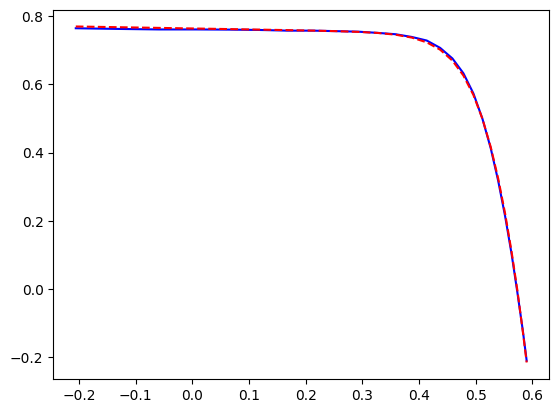

In [32]:
pred = Panel(xmin,VL,IL)+IL
plt.plot(VL,IL,'b')
plt.plot(VL,pred,'r--')

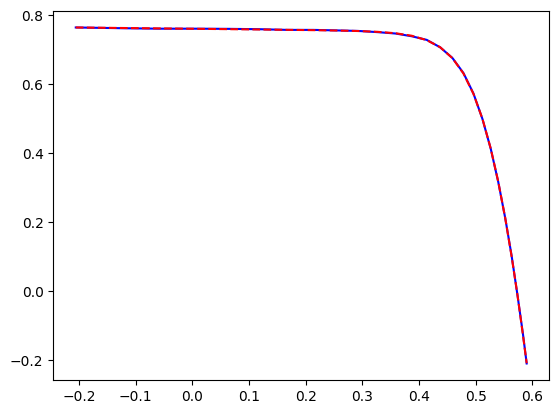

In [33]:
pred = Panel(bestParams,VL,IL)+IL
plt.plot(VL,IL,'b')
plt.plot(VL,pred,'r--')

In [34]:
RMSE(xmin,VL,IL),RMSE(bestParams,VL,IL)

(Array(0.00429453, dtype=float32), Array(0.00102143, dtype=float32))